In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
def rectangle(x0, x1, v_const, dt=0.001):
    """
    โปรไฟล์ความเร็วคงที่ (ideal) — ไม่มีช่วงเร่ง/เบรก
    หมายเหตุ: ในโลกจริงจะต้องมีช่วงเร่ง/เบรก (ไม่เช่นนั้น a, j อนันต์ที่ต้น/ปลาย)
    """
    D_signed = x1 - x0
    s = 1 if D_signed >= 0 else -1
    D = abs(D_signed)

    # --- กรณีระยะ=0 หรือ v_const ไม่เหมาะสม: หยุดนิ่ง ---
    if D < 1e-12 or v_const <= 1e-12:
        t = np.array([0.0, dt])  # อย่างน้อย 2 จุด
        x = np.array([0.0, 0.0])
        v = np.array([0.0, 0.0])
        a = np.array([0.0, 0.0])
        j = np.array([0.0, 0.0])
        return t, x0 + s*x, s*v, s*a, s*j

    # --- เวลาเดินทางรวม ---
    T_total = D / v_const

    # ให้มีอย่างน้อย 2 sample และลงท้ายที่ T_total พอดี
    N = max(2, int(np.ceil(T_total / dt)) + 1)
    t = np.linspace(0.0, T_total, N)

    # โปรไฟล์ ideal: v คงที่, a=0, j=0 (ทางทฤษฎีจะมีอิมพัลส์ที่ t=0 และ t=T_total)
    x = v_const * t
    v = np.full_like(t, v_const, dtype=float)
    a = np.zeros_like(t, dtype=float)
    j = np.zeros_like(t, dtype=float)

    return t, x0 + s*x, s*v, s*a, s*j


In [9]:
# ========== Trapezoid 3-phase (with numeric jerk) ==========
def trapezoid(x0, x1, v_max, a_max, dt=0.001):
    D  = x1 - x0
    s  = 1 if D >= 0 else -1
    D  = abs(D)

    # --- ตรวจว่าถึง v_max ได้ไหม ---
    D_need_for_vmax = (v_max**2) / a_max  # ระยะที่ต้องใช้เพื่อเร่ง+เบรกถึง v_max
    if D >= D_need_for_vmax:
        # โปรไฟล์ trapezoid ปกติ (มีช่วงคงที่)
        Ta = v_max / a_max           # เวลาเร่ง (และเบรก)
        Da = 0.5 * a_max * Ta**2     # ระยะฝั่งเร่ง (เท่ากับฝั่งเบรก)
        Dc = D - 2*Da                # ระยะช่วงคงที่
        Tv = Dc / v_max              # เวลาช่วงคงที่
    else:
        # โปรไฟล์สามเหลี่ยม: ไปไม่ถึง v_max
        v_max = np.sqrt(a_max * D)   # v_peak feasible
        Ta = v_max / a_max
        Tv = 0.0
        Da = 0.5 * a_max * Ta**2
        Dc = 0.0

    T_total = 2*Ta + Tv
    t = np.arange(0.0, T_total + 1e-12, dt)

    x = np.zeros_like(t)
    v = np.zeros_like(t)
    a = np.zeros_like(t)

    for i, ti in enumerate(t):
        if ti < Ta:  # accel
            a[i] = a_max
            v[i] = a_max * ti
            x[i] = 0.5 * a_max * ti**2

        elif ti < Ta + Tv:  # cruise (ถ้ามี)
            a[i] = 0.0
            v[i] = v_max
            x[i] = Da + v_max * (ti - Ta)

        else:  # decel
            td  = ti - (Ta + Tv)
            a[i] = -a_max
            v[i] = v_max - a_max * td
            x[i] = Da + Dc + v_max*td - 0.5*a_max*td**2

    # --- คำนวณ jerk แบบเชิงตัวเลข (แนะนำสำหรับการ plot/วิเคราะห์) ---
    # หมายเหตุ: ในทฤษฎี jerk เป็น "อิมพัลส์" (อนันต์) ที่เวลารอยต่อ: 0, Ta, Ta+Tv, T_total
    j = np.gradient(a.astype(float), dt)

    return t, x0 + s*x, s*v, s*a, s*j

In [10]:
def s_curve(x0, x1, v_max, a_max, j_max, dt=0.001):
    """
    7-phase jerk-limited S-curve (third-order)
    Return: t, x, v, a, j
    """
    D_signed = x1 - x0
    s = 1 if D_signed >= 0 else -1
    D = abs(D_signed)
    if D < 1e-15:
        t = np.array([0.0])
        return t, np.array([x0]), np.array([0.0]), np.array([0.0]), np.array([0.0])

    # --- เลือก Tj เบื้องต้นจากเพดาน a และ v (สูตรมาตรฐาน S-curve) ---
    Tj = min(a_max / j_max, v_max / a_max)
    # --- เลือกชนิดช่วงเร่งอย่างถูกต้อง (third-order S-curve) ---
    if v_max >= (a_max * a_max) / j_max:
        # ถึง a_max ได้ (ทราเพโซอิดฝั่งเร่ง)
        Tj = a_max / j_max
        Tc = (v_max / a_max) - Tj       # >= 0
    else:
        # ไม่ถึง a_max (สามเหลี่ยมฝั่งเร่ง)
        Tj = np.sqrt(v_max / j_max)
        Tc = 0.0

    # --- คำนวณใหม่ทั้งหมดด้วย Tj/Tc ที่ “สรุปแล้ว” ---
    a_reached = min(a_max, j_max * Tj)        # ถ้าเป็นสามเหลี่ยม a_reached < a_max
    x1a = (1/6) * j_max * Tj**3
    v1a = 0.5 * j_max * Tj**2
    x2a = v1a * Tc + 0.5 * a_reached * Tc**2
    v2a = v1a + a_reached * Tc
    x3a = v2a * Tj + 0.5 * a_reached * Tj**2 - (1/6) * j_max * Tj**3
    v_peak = v2a + a_reached * Tj - 0.5 * j_max * Tj**2
    D_no_cruise = 2.0 * (x1a + x2a + x3a)

    # --- ตัดสินว่ามี cruise ไหม จากค่าที่เพิ่งคำนวณใหม่ ---
    if D_no_cruise <= D + 1e-12:
        Tv = (D - D_no_cruise) / max(v_peak, 1e-12)   # มี cruise หรือพอดี
    else:
        # ระยะสั้นเกิน → ไม่มี cruise: แก้โปรไฟล์ให้สั้นลง
        # 5-phase (ถึง a_reached) หรือ 3-phase (ไม่ถึง a_reached) ตามกรณี
        # วิธีง่าย: แก้ v_peak ใหม่ด้วยการแก้สมการระยะ (เวอร์ชันย่อ)
        # ---- ทางเลือกสั้น: ใช้ตัวแก้ของคุณเดิม แต่ต้อง "คำนวณ x1a.. v_peak.. D_no_cruise ใหม่" หลังได้ Tj/Tc ใหม่ทุกครั้ง ----
        j = j_max
        Tj_try = a_reached / j  # = Tj ถ้าเป็นสามเหลี่ยม; = a_max/j ถ้าเป็นทราเพโซฯ
        A = 1.0
        B = 3.0 * Tj_try
        C = 2.0 * Tj_try**2 - (D / (j * Tj_try))
        disc = B*B - 4*A*C
        Tc = max(0.0, (-B + np.sqrt(max(0.0, disc))) / (2*A))
        Tj = Tj_try
        # คำนวณใหม่ทั้งหมดอีกครั้งหลังได้ Tj/Tc สุดท้าย
        a_reached = min(a_max, j_max * Tj)
        x1a = (1/6) * j_max * Tj**3
        v1a = 0.5 * j_max * Tj**2
        x2a = v1a * Tc + 0.5 * a_reached * Tc**2
        v2a = v1a + a_reached * Tc
        x3a = v2a * Tj + 0.5 * a_reached * Tj**2 - (1/6) * j_max * Tj**3
        v_peak = v2a + a_reached * Tj - 0.5 * j_max * Tj**2
        Tv = 0.0


    # --- ความเร่งที่ "ถึงจริง" (สำคัญมากสำหรับเคส Tc=0) ---
    a_reached = min(a_max, j_max*Tj)

    # --- ป้องกันเลขลบเล็กน้อย + คำนวณหมุดเวลาใหม่ ---
    Tv = max(0.0, Tv)
    t1 = Tj
    t2 = Tj + Tc
    t3 = 2*Tj + Tc             # Ta
    t4 = t3 + Tv
    t5 = t4 + Tj
    t6 = t5 + Tc
    t7 = t6 + Tj
    T_total = t7

    # --- ค่า ณ เวลาใดๆ (ใช้ a_reached เสมอเมื่อไม่มีช่วงถึง a_max จริง) ---
    def seg_values_at(t):
        if t < t1:  # 1) +jerk
            tau = t
            j = j_max
            a = j_max*tau
            v = 0.5*j_max*tau**2
            x = (1/6)*j_max*tau**3

        elif t < t2:  # 2) +a const
            tau = t - t1
            j = 0.0
            a = a_reached
            v = v1a + a_reached*tau
            x = x1a + v1a*tau + 0.5*a_reached*tau**2

        elif t < t3:  # 3) -jerk
            tau = t - t2
            j = -j_max
            a = a_reached - j_max*tau
            v = v2a + a_reached*tau - 0.5*j_max*tau**2
            x = x1a + x2a + v2a*tau + 0.5*a_reached*tau**2 - (1/6)*j_max*tau**3

        elif t < t4:  # 4) const vel
            tau = t - t3
            j = 0.0
            a = 0.0
            v = v_peak
            x = (x1a + x2a + x3a) + v*tau

        elif t < t5:  # 5) -jerk (เริ่มเบรก)
            tau = t - t4
            j = -j_max
            a = -j_max*tau
            v = v_peak - 0.5*j_max*tau**2
            x = (x1a + x2a + x3a) + v_peak*Tv + v_peak*tau - (1/6)*j_max*tau**3

        elif t < t6:  # 6) -a const
            tau = t - t5
            j = 0.0
            a = -a_reached
            v = (v_peak - 0.5*j_max*Tj**2) + (-a_reached)*tau
            x = (x1a + x2a + x3a) + v_peak*Tv + (v_peak*Tj - (1/6)*j_max*Tj**3) \
                + (v_peak - 0.5*j_max*Tj**2)*tau - 0.5*a_reached*tau**2

        else:        # 7) +jerk (ปล่อยเบรก)
            tau = t - t6
            j = j_max
            a = -a_reached + j_max*tau
            v = (v_peak - 0.5*j_max*Tj**2) - a_reached*Tc - a_reached*tau + 0.5*j_max*tau**2
            x_t6 = (x1a + x2a + x3a) + v_peak*Tv + (v_peak*Tj - (1/6)*j_max*Tj**3) \
                 + (v_peak - 0.5*j_max*Tj**2)*Tc - 0.5*a_reached*Tc**2
            x = x_t6 + ((v_peak - 0.5*j_max*Tj**2) - a_reached*Tc)*tau \
                 - 0.5*a_reached*tau**2 + (1/6)*j_max*tau**3

        return x, v, a, j

    # --- สุ่มตามเวลา: ให้ลงท้ายที่ T_total เป๊ะ และ snap ปลายทาง ---
    N = max(1, int(np.ceil(T_total/dt)))
    t = np.linspace(0.0, T_total, N+1)
    X = np.zeros_like(t); V = np.zeros_like(t); A = np.zeros_like(t); J = np.zeros_like(t)
    for i, ti in enumerate(t):
        x, v, a, j = seg_values_at(ti)
        X[i] = x; V[i] = v; A[i] = a; J[i] = j

    return t, x0 + s*X, s*V, s*A, s*J

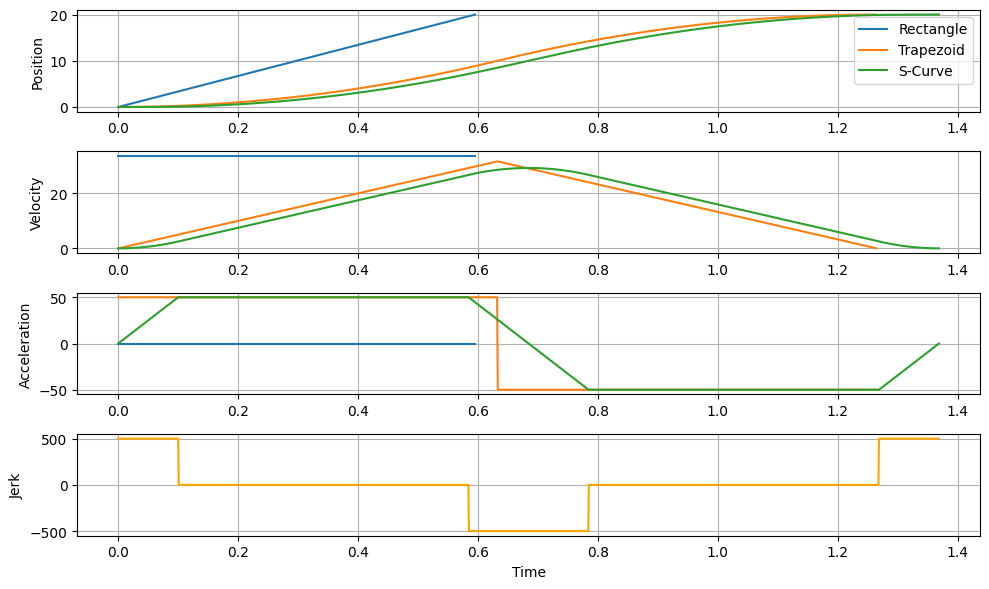

In [11]:
# ===== Demo =====
start_point = 0
end_point = 20
max_velocity = 33.6
max_accel = 50
max_jerk = 500
t1,x1,v1,a1,j1 = rectangle(start_point,end_point,max_velocity,max_accel)
t2,x2,v2,a2,j2 = trapezoid(start_point,end_point,max_velocity,max_accel)
t3,x3,v3,a3,j3 = s_curve(start_point,end_point,max_velocity,max_accel,max_jerk)

plt.figure(figsize=(10,6))
plt.subplot(4,1,1); plt.plot(t1,x1,label="Rectangle"); plt.plot(t2,x2,label="Trapezoid"); plt.plot(t3,x3,label="S-Curve"); plt.ylabel("Position"); plt.legend(); plt.grid()
plt.subplot(4,1,2); plt.plot(t1,v1); plt.plot(t2,v2); plt.plot(t3,v3); plt.ylabel("Velocity"); plt.grid()
plt.subplot(4,1,3); plt.plot(t1,a1); plt.plot(t2,a2); plt.plot(t3,a3); plt.ylabel("Acceleration"); plt.grid()
plt.subplot(4,1,4); plt.plot(t3,j3, c="orange"); plt.ylabel("Jerk"); plt.xlabel("Time"); plt.grid()
plt.tight_layout(); plt.show()

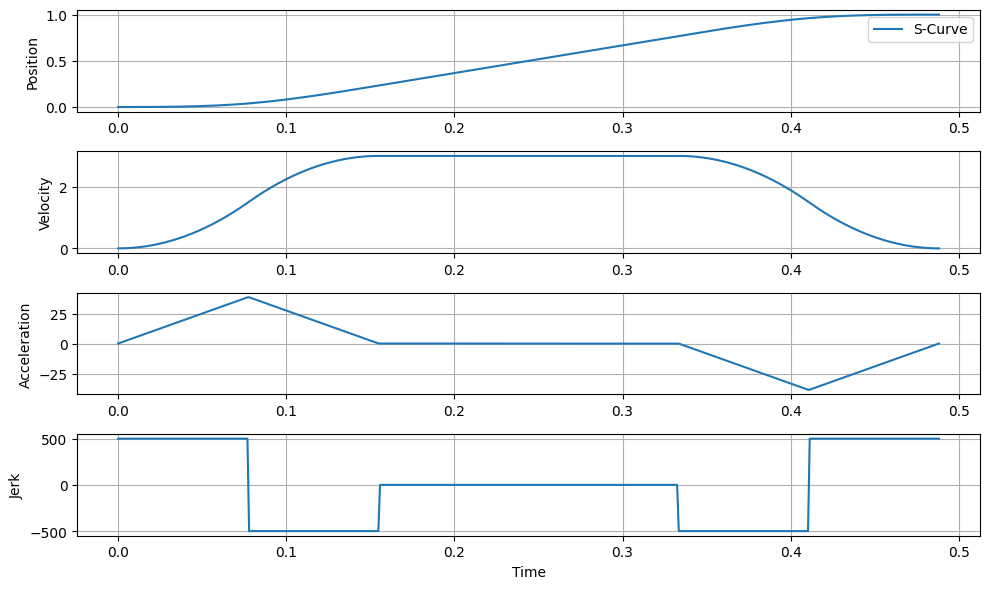

In [12]:
# ===== Demo =====
start_point = 0
end_point = 1
max_velocity = 3
max_accel = 50
max_jerk = 500
t,x,v,a,j = s_curve(start_point,end_point,max_velocity,max_accel,max_jerk)

plt.figure(figsize=(10,6))
plt.subplot(4,1,1); plt.plot(t,x,label="S-Curve"); plt.ylabel("Position"); plt.legend(); plt.grid()
plt.subplot(4,1,2); plt.plot(t,v); plt.ylabel("Velocity"); plt.grid()
plt.subplot(4,1,3); plt.plot(t,a); plt.ylabel("Acceleration"); plt.grid()
plt.subplot(4,1,4); plt.plot(t,j); plt.ylabel("Jerk"); plt.xlabel("Time"); plt.grid()
plt.tight_layout(); plt.show()